### Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from scipy import stats

import sklearn.linear_model as lm
from sklearn import model_selection
from sklearn.metrics import mean_squared_error,mean_absolute_error  

import torch

### Import Scripts

In [2]:
from functions import *
from data_preprocess import *

### Select Regression Attribute

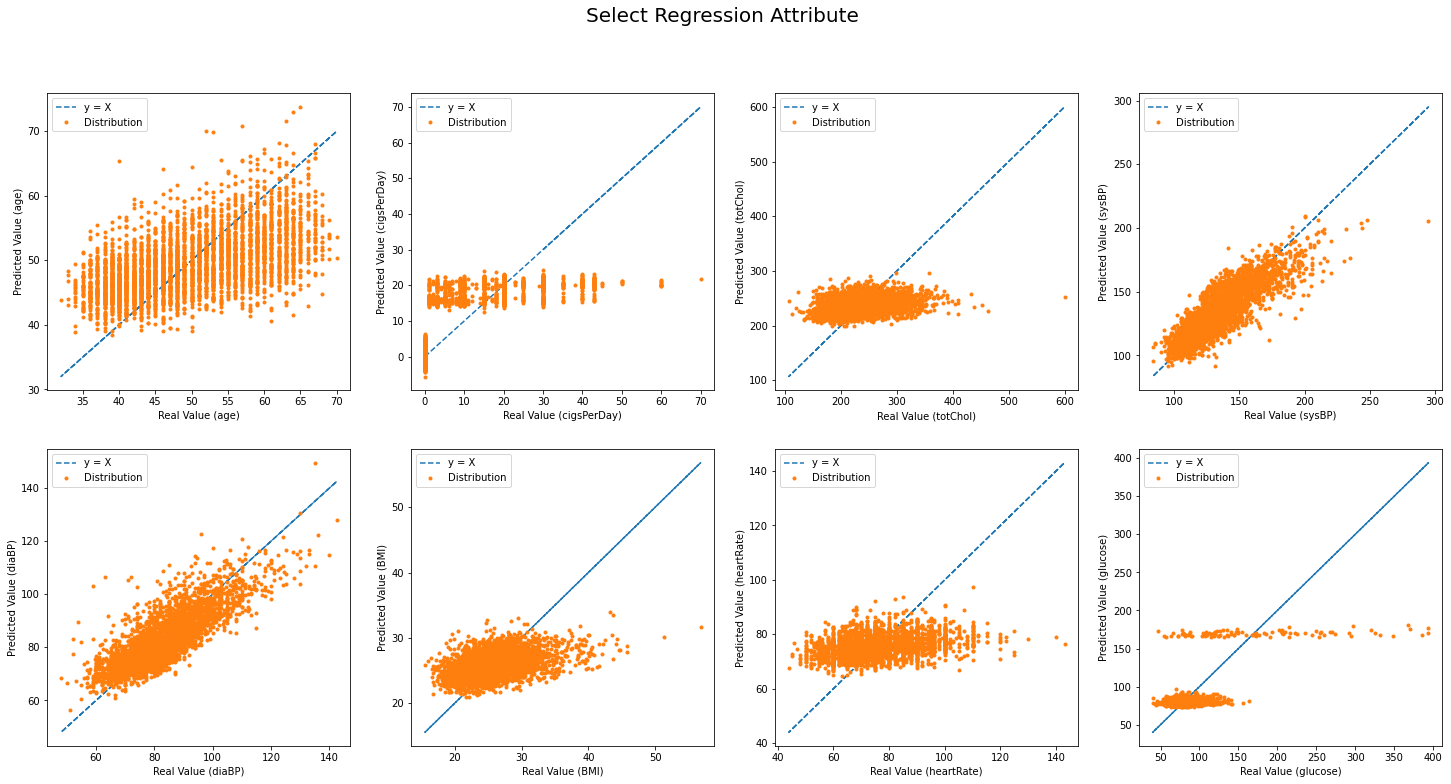

In [3]:
#Ratio Attributes
ratio = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']

#Figure Settings
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(25,12), sharex=False)
fig.suptitle("Select Regression Attribute", fontsize=20)

for i in range(len(ratio)):
    #Splitting the Predicted Value from the Attributes
    idx_y = list(data.columns).index(ratio[i])
    idx_X = list(range(0, idx_y)) + list(range(idx_y + 1, len(data.columns)))
    X = data_np[:, idx_X]
    y = data_np[:, idx_y]
    attributeNames = list(data.columns[idx_X])
    N, M = X.shape
    
    #Normalize the Data
    X = stats.zscore(X)
    
    #Creating the Model
    model = lm.LinearRegression()
    model.fit(X,y)
    
    #Prediction
    y_pred = model.predict(X)

    #Plotting
    axes[i//4,i%4].plot(y, y, '--')
    axes[i//4,i%4].plot(y, y_pred, '.')
    axes[i//4,i%4].set(xlabel = 'Real Value ({0})'.format(ratio[i])) 
    axes[i//4,i%4].set(ylabel = 'Predicted Value ({0})'.format(ratio[i]))
    axes[i//4,i%4].legend(['y = X', 'Distribution'])

plt.savefig('Select Regression.png')
plt.show()

### Create the Regression Dataset

In [4]:
#Splitting the Predicted Value from the Attributes
idx_y = list(data.columns).index('sysBP')
idx_X = list(range(0, idx_y)) + list(range(idx_y + 1, len(data.columns)))
X = data_np[:, idx_X]
y = data_np[:, idx_y]
attributeNames = list(data.columns[idx_X])
N, M = X.shape

#Normalize the Data
X = stats.zscore(X)

### Feature Selection

Cross validation fold 1/10
Features no: 10

Cross validation fold 2/10
Features no: 10

Cross validation fold 3/10
Features no: 11

Cross validation fold 4/10
Features no: 9

Cross validation fold 5/10
Features no: 12

Cross validation fold 6/10
Features no: 10

Cross validation fold 7/10
Features no: 11

Cross validation fold 8/10
Features no: 13

Cross validation fold 9/10
Features no: 9

Cross validation fold 10/10
Features no: 10



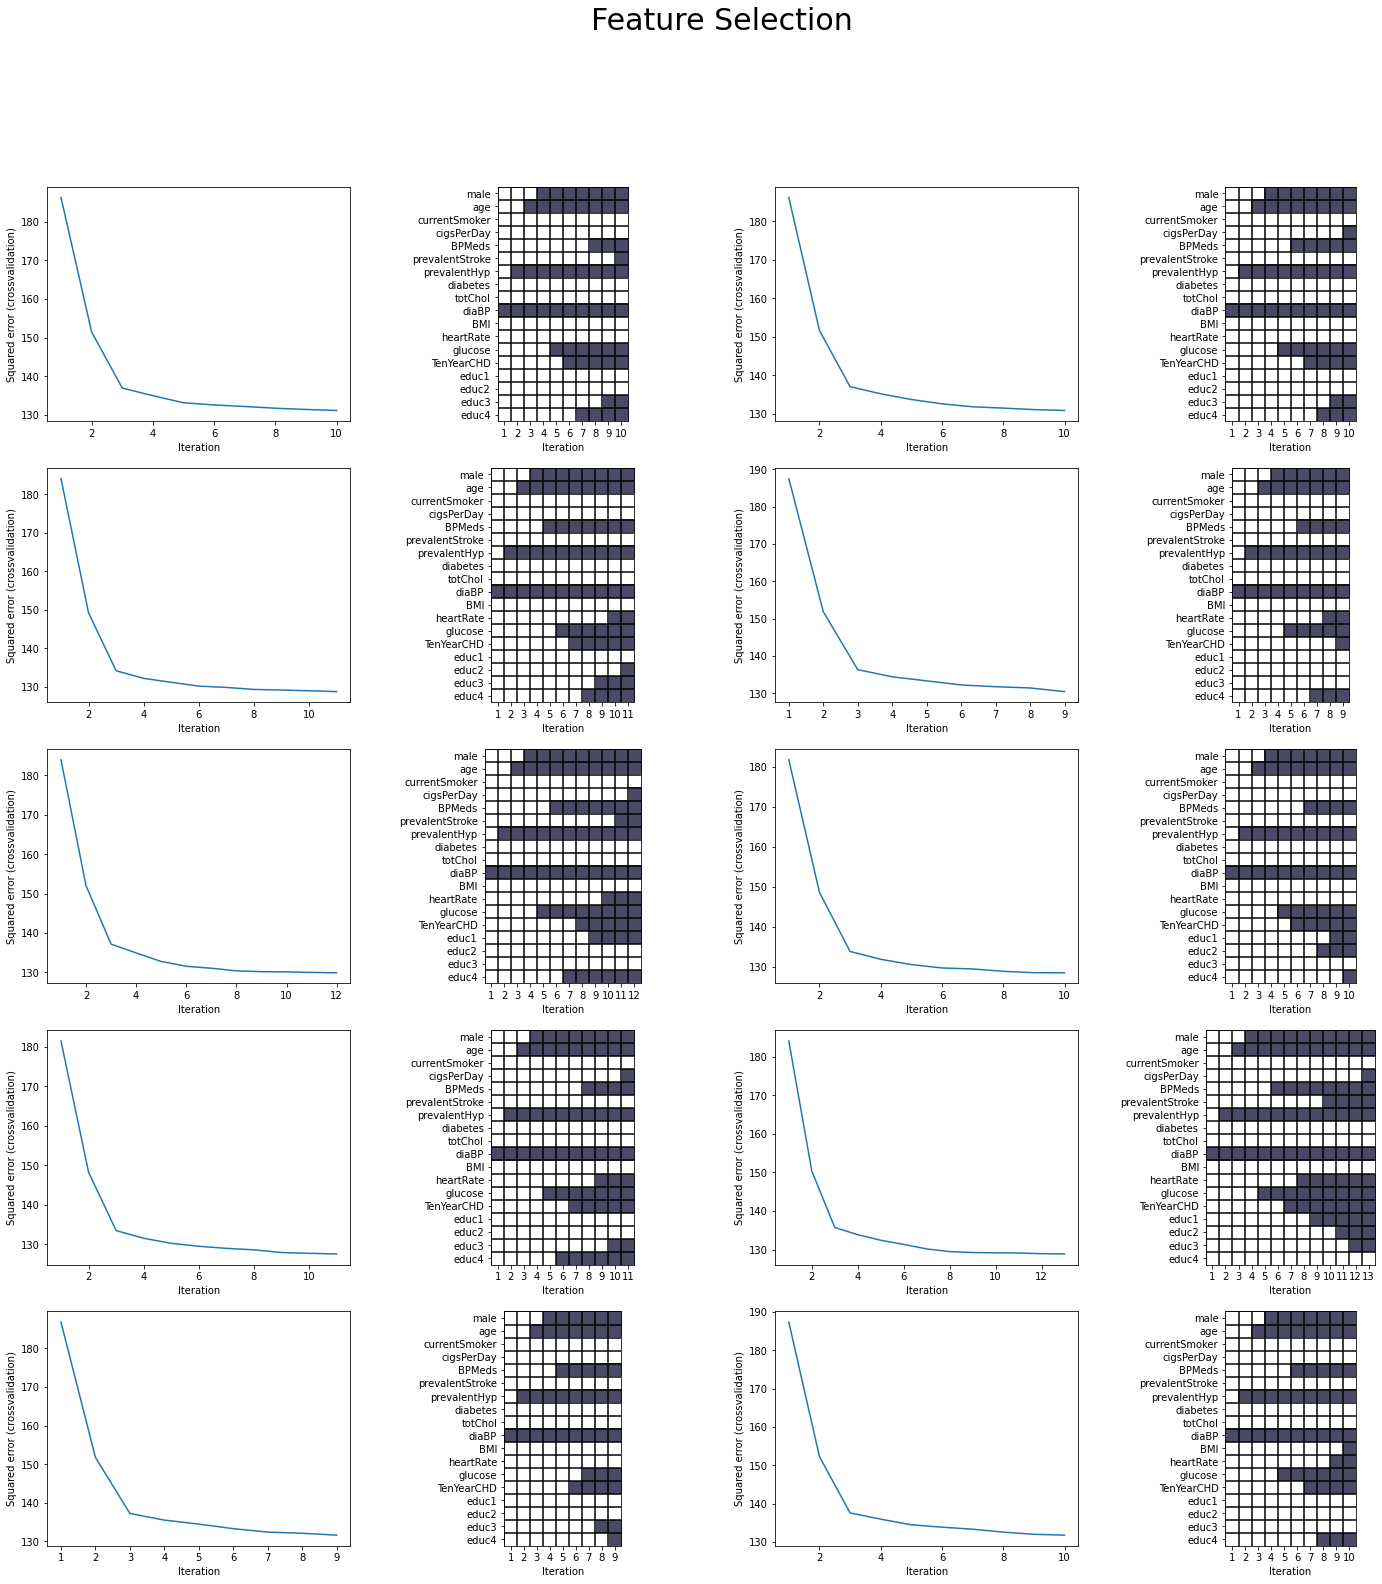

In [5]:
#Figure Settings
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(25,25), sharex=False)
fig.suptitle("Feature Selection", fontsize=30)

#Cross Validation Selection
K = 10
CV = model_selection.KFold(n_splits=K, shuffle=True)

#Initialize Error Variables
features = np.zeros((M,K))
error_train = np.empty((K,1))
error_test = np.empty((K,1))
error_train_fs = np.empty((K,1))
error_test_fs = np.empty((K,1))
error_train_nofeatures = np.empty((K,1))
error_test_nofeatures = np.empty((K,1))

#Counter
counter_plot = 1

#Feature Selection with Cross Validation
for (k, (train_index, test_index)) in enumerate(CV.split(X, y)):
    #Extract Training and Test Set for Current CV Fold
    X_train = X[train_index,:]
    y_train = y[train_index]
    X_test = X[test_index,:]
    y_test = y[test_index]
    internal_cross_validation = 10
    
    #Compute Squared Error Without Using the Input Data at All
    error_train_nofeatures[k] = np.square(y_train-y_train.mean()).sum()/y_train.shape[0]
    error_test_nofeatures[k] = np.square(y_test-y_test.mean()).sum()/y_test.shape[0]

    #Compute Squared Error with All Features Selected (no feature selection)
    lr_model = lm.LinearRegression(fit_intercept=True).fit(X_train, y_train)
    error_train[k] = np.square(y_train-lr_model.predict(X_train)).sum()/y_train.shape[0]
    error_test[k] = np.square(y_test-lr_model.predict(X_test)).sum()/y_test.shape[0]
    
    #Compute Squared Error with Feature Subset Selection
    textout = ''
    selected_features, features_record, loss_record = feature_selector_lr(X_train, y_train, internal_cross_validation,display=textout)
    features[selected_features,k] = 1
    
    if len(selected_features) == 0:
        print('No features were selected, i.e. the data (X) in the fold cannot describe the outcomes (y).' )
    else:
        lr_model = lm.LinearRegression(fit_intercept=True).fit(X_train[:,selected_features], y_train)
        error_train_fs[k] = np.square(y_train-lr_model.predict(X_train[:,selected_features])).sum()/y_train.shape[0]
        error_test_fs[k] = np.square(y_test-lr_model.predict(X_test[:,selected_features])).sum()/y_test.shape[0]
    
        plt.subplot(5, 4, counter_plot)
        plt.plot(range(1,len(loss_record)), loss_record[1:])
        plt.xlabel('Iteration')
        plt.ylabel('Squared error (crossvalidation)')    
        
        plt.subplot(5, 4, counter_plot + 1)
        bmplot(attributeNames, range(1,features_record.shape[1]), -features_record[:,1:])
        plt.clim(-1.5,0)
        plt.xlabel('Iteration')
    print('Cross validation fold {0}/{1}'.format(k+1,K))
    print('Features no: {0}\n'.format(selected_features.size))

    counter_plot+=2

In [6]:
print('Linear regression without feature selection:')
print('- Training error: {0}'.format(error_train.mean()))
print('- Test error:     {0}'.format(error_test.mean()))
print('- R^2 train:     {0}'.format((error_train_nofeatures.sum()-error_train.sum())/error_train_nofeatures.sum()))
print('- R^2 test:     {0}'.format((error_test_nofeatures.sum()-error_test.sum())/error_test_nofeatures.sum()))
print('\n')
print('Linear regression with feature selection:')
print('- Training error: {0}'.format(error_train_fs.mean()))
print('- Test error:     {0}'.format(error_test_fs.mean()))
print('- R^2 train:     {0}'.format((error_train_nofeatures.sum()-error_train_fs.sum())/error_train_nofeatures.sum()))
print('- R^2 test:     {0}'.format((error_test_nofeatures.sum()-error_test_fs.sum())/error_test_nofeatures.sum()))

Linear regression without feature selection:
- Training error: 128.73587536496342
- Test error:     130.75835866144627
- R^2 train:     0.7334835282850661
- R^2 test:     0.7287726639366376


Linear regression with feature selection:
- Training error: 129.07346194332547
- Test error:     130.73052340393883
- R^2 train:     0.7327846369813926
- R^2 test:     0.7288304016049569


### Results from All Cross Validations

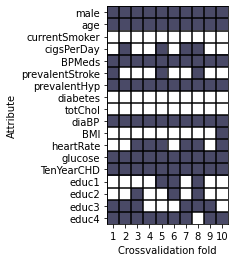

In [7]:
plt.figure(k)
bmplot(attributeNames, range(1,features.shape[1]+1), -features)
plt.clim(-1.5,0)
plt.xlabel('Crossvalidation fold')
plt.ylabel('Attribute')
plt.savefig('Feature Selection.png')
plt.show()

### Create New DataFrame with Less Features

In [8]:
#Create new DataFrame with Selected Features
data_fs = data[['male', 'age', 'BPMeds', 'prevalentHyp', 'sysBP', 'diaBP', 'heartRate', 'glucose', 'TenYearCHD', 'educ4']]

#DataFrame to NumPy Array
data_np_fs = data_fs.to_numpy()

#Splitting the Predicted Value from the Attributes
idx_y = list(data_fs.columns).index('sysBP')
idx_X = list(range(0, idx_y)) + list(range(idx_y + 1, len(data_fs.columns)))
X = data_np_fs[:, idx_X]
y = data_np_fs[:, idx_y]
attributeNames = list(data_fs.columns[idx_X])
N, M = X.shape

#Normalize the Data
X = stats.zscore(X)

### Regularization Parameter $\lambda$

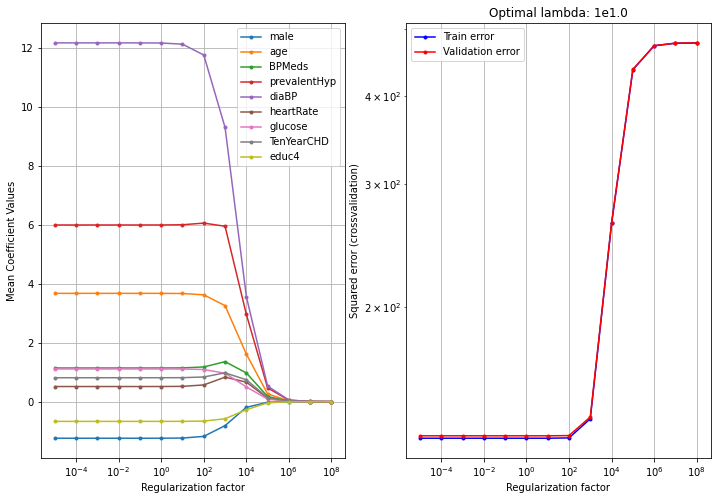

In [9]:
#Add Offset Attribute
X = np.concatenate((np.ones((X.shape[0],1)),X),1)
attributeNames = [u'Offset'] + attributeNames
M = M + 1

#Create Cross Validation Partition for Evaluation
K = 10
CV = model_selection.KFold(K, shuffle=True)

#Values of Lambda
lambdas = np.power(10.,range(-5,9))

#Initialize Variables
error_train = np.empty((K,1))
error_test = np.empty((K,1))
error_train_rlr = np.empty((K,1))
error_test_rlr = np.empty((K,1))
error_train_nofeatures = np.empty((K,1))
error_test_nofeatures = np.empty((K,1))
error_lambdas = np.empty((K,len(lambdas)))

w_rlr = np.empty((M,K))
w_noreg = np.empty((M,K))

mu = np.empty((K, M-1))
sigma = np.empty((K, M-1))

y_pred_all = []
y_test_all = []
residuals_all = []

for (k, (train_index, test_index)) in enumerate(CV.split(X,y)):        
    #Extract Training and Test Set for Current CV Fold
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    y_test_all.append(y_test)
    internal_cross_validation = 10   
    opt_val_err, opt_lambda, mean_w_vs_lambda, train_err_vs_lambda, test_err_vs_lambda = rlr_validate(X_train, y_train, lambdas, internal_cross_validation)
    
    mu[k, :] = np.mean(X_train[:, 1:], 0)
    sigma[k, :] = np.std(X_train[:, 1:], 0)
    
    X_train[:, 1:] = (X_train[:, 1:] - mu[k, :] ) / sigma[k, :] 
    X_test[:, 1:] = (X_test[:, 1:] - mu[k, :] ) / sigma[k, :] 
    
    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train
    
    #Compute the lambda's error
    error_lambdas[k] = test_err_vs_lambda
    
    #Compute Mean Squared Error Without Using the Input Data at All
    error_train_nofeatures[k] = np.square(y_train-y_train.mean()).sum(axis=0)/y_train.shape[0]
    error_test_nofeatures[k] = np.square(y_test-y_test.mean()).sum(axis=0)/y_test.shape[0]
    
    #Estimate Weights for the Optimal Value of lambda, on Entire Training Set
    lambdaI = opt_lambda * np.eye(M)
    lambdaI[0,0] = 0 
    w_rlr[:,k] = np.linalg.solve(XtX+lambdaI,Xty).squeeze()
    
    #Compute Mean Squared Error with Regularization with Optimal lambda
    error_train_rlr[k] = np.square(y_train-X_train @ w_rlr[:,k]).sum(axis=0)/y_train.shape[0]
    error_test_rlr[k] = np.square(y_test-X_test @ w_rlr[:,k]).sum(axis=0)/y_test.shape[0]   
    
    #Compute Residuals
    y_pred_rlr = (X_test @ w_rlr[:,k])
    y_pred_all.append(y_pred_rlr)
    residuals_rlr = y_pred_rlr - y_test  
    residuals_all.append(residuals_rlr)
    
    #Estimate Weights for Unregularized Linear Regression, on Entire Training Set
    w_noreg[:,k] = np.linalg.solve(XtX,Xty).squeeze()
    
    #Compute Mean Squared Error Without Regularization
    error_train[k] = np.square(y_train-X_train @ w_noreg[:,k]).sum(axis=0)/y_train.shape[0]
    error_test[k] = np.square(y_test-X_test @ w_noreg[:,k]).sum(axis=0)/y_test.shape[0]
    
    #Display the Results for the Last Cross-Validation Fold
    if k == K-1:
        plt.figure(k, figsize=(12,8))
        
        plt.subplot(1,2,1)
        plt.semilogx(lambdas,mean_w_vs_lambda.T[:,1:],'.-') 
        plt.xlabel('Regularization factor')
        plt.ylabel('Mean Coefficient Values')
        plt.grid()
        plt.legend(attributeNames[1:], loc='best')
        
        plt.subplot(1,2,2)
        plt.title('Optimal lambda: 1e{0}'.format(np.log10(opt_lambda)))
        plt.loglog(lambdas,train_err_vs_lambda.T,'b.-',lambdas,test_err_vs_lambda.T,'r.-')
        plt.xlabel('Regularization factor')
        plt.ylabel('Squared error (crossvalidation)')
        plt.legend(['Train error','Validation error'])
        plt.grid()

plt.savefig('Optimal lampda.png')
plt.show()

In [10]:
#Display Results
print('Linear regression without feature selection:')
print('- Training error: {0}'.format(error_train.mean()))
print('- Test error:     {0}'.format(error_test.mean()))
print('- R^2 train:     {0}'.format((error_train_nofeatures.sum()-error_train.sum())/error_train_nofeatures.sum()))
print('- R^2 test:     {0}\n'.format((error_test_nofeatures.sum()-error_test.sum())/error_test_nofeatures.sum()))

print('Regularized linear regression:')
print('- Training error: {0}'.format(error_train_rlr.mean()))
print('- Test error:     {0}'.format(error_test_rlr.mean()))
print('- R^2 train:     {0}'.format((error_train_nofeatures.sum()-error_train_rlr.sum())/error_train_nofeatures.sum()))
print('- R^2 test:     {0}\n'.format((error_test_nofeatures.sum()-error_test_rlr.sum())/error_test_nofeatures.sum()))

Linear regression without feature selection:
- Training error: 129.2311366973191
- Test error:     130.20152857463793
- R^2 train:     0.7324557885118052
- R^2 test:     0.7297292636909748

Regularized linear regression:
- Training error: 129.23243732572428
- Test error:     130.2002606912032
- R^2 train:     0.7324530958511198
- R^2 test:     0.72973189554786



### Select K-Fold with Less Test Error

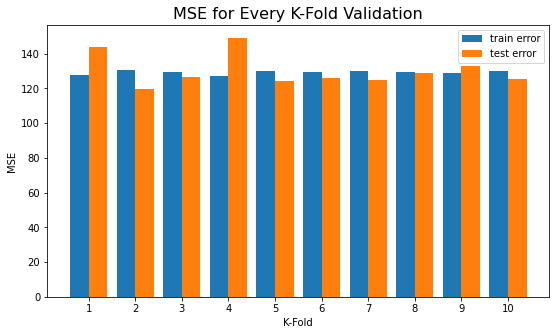

In [11]:
plt.figure(figsize=(9,5))

plt.bar(np.arange(10) - 0.4/2, np.squeeze(np.asarray(error_train_rlr)), 0.4, label='train error')
plt.bar(np.arange(10) + 0.4/2, np.squeeze(np.asarray(error_test_rlr)), 0.4, label='test error')
plt.xlabel('K-Fold')
plt.ylabel('MSE')
plt.title('MSE for Every K-Fold Validation', fontsize=16)
plt.xticks(np.arange(10), ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
plt.legend()
plt.savefig('MSE for every K.png')
plt.show()

### Print Minimum MSE

In [12]:
print("MSE: ", np.min(error_test_rlr))

MSE:  119.41458358247728


### Calculate Index of Minimum MSE

In [13]:
idx = np.argmin(error_test_rlr)

### Weights of the Regression Model

In [14]:
#Display Weights
print('Weights in Fifth fold:')
for m in range(M):
    print('{:>15} {:>15}'.format(attributeNames[m], np.round(w_rlr[m,idx],2)))

Weights in Fifth fold:
         Offset          132.21
           male           -1.32
            age            3.64
         BPMeds            0.95
   prevalentHyp            5.77
          diaBP           12.54
      heartRate            0.49
        glucose            1.14
     TenYearCHD            1.02
          educ4           -0.71


### Residuals

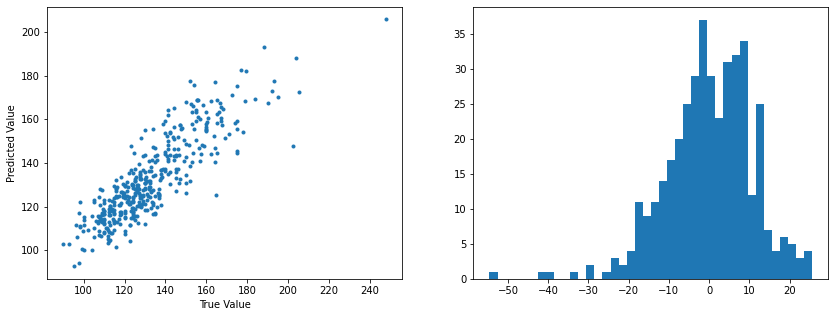

In [15]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(y_test_all[idx], y_pred_all[idx], '.')
plt.xlabel('True Value') 
plt.ylabel('Predicted Value')

plt.subplot(1,2,2)
plt.hist(residuals_all[idx],40)
plt.savefig('Residuals.png')
plt.show()